# Data Science Capstone - LSTM COVID UK Cases

### 1 ETL Process

##### 1.1 Import dataset from PHE website

In [1]:
import pandas as pd
import io
import requests

import warnings
warnings.filterwarnings('ignore')

CovidUrl="https://coronavirus.data.gov.uk/downloads/csv/coronavirus-cases_latest.csv"
CovidRequest=requests.get(CovidUrl).content
CovidImport=pd.read_csv(io.StringIO(CovidRequest.decode('utf-8')))


In [2]:
CovidImportData = CovidImport[['Area code','Specimen date','Daily lab-confirmed cases','Cumulative lab-confirmed cases']]

CovidImportData.columns = ['key','date','Daily cases','Cumulative cases']

CovidImportData.head()

,key,date,Daily cases,Cumulative cases
0,E07000223,2020-10-12,0,287
1,E07000223,2020-10-11,1,287
2,E07000223,2020-10-10,1,286
3,E07000223,2020-10-09,2,285
4,E07000223,2020-10-08,2,283


##### 1.2 Import population information

In [3]:
import json


metaUrl = "https://api.beta.ons.gov.uk/v1/datasets/mid-year-pop-est"
metaUrlRequest = requests.get(metaUrl)
filterMeta = json.loads(metaUrlRequest.text)
latestVersionmetaURL = filterMeta["links"]["latest_version"]["href"]
latestVersionmetaURLRequest = requests.get(latestVersionmetaURL)
filterLatestVersion = json.loads(latestVersionmetaURLRequest.text)

populationDataURL = filterLatestVersion["downloads"]["csv"]["href"]

populationDataRequest = requests.get(populationDataURL).content
populationDataImport = pd.read_csv(io.StringIO(populationDataRequest.decode('utf-8')))

populationDataImport.head()

,v4_0,calendar-years,time,admin-geography,geography,mid-year-pop-sex,sex,mid-year-pop-age,age
0,455,2001,2001,E06000005,Darlington,1,Male,64,64
1,386,2001,2001,E06000005,Darlington,1,Male,69,69
2,581,2001,2001,E06000005,Darlington,0,All,81,81
3,1093,2001,2001,E06000004,Stockton-on-Tees,2,Female,22,22
4,259,2001,2001,E06000005,Darlington,0,All,87,87


##### 1.3 Wrangle download from ONS API of JSON

In [4]:
#print(populationDataImport.columns)

#populationV1 = populationDataImport.filter('calendar-years' = 2019, axis = 1)

population = populationDataImport[populationDataImport['calendar-years'] == 2019]
population = population[population['sex'] == "All"]
population = population[population['age'] == "Total"]

population = population[['admin-geography','geography','v4_0']]

population.columns = ['key','geography','population total']

population[population['key'] == "E07000005"]

,key,geography,population total


##### 1.4 Join cases and population together and standardise

In [5]:
populationJoin = population.set_index('key')
CovidImportJoin = CovidImportData.set_index('key')

CovidCasesJoin = CovidImportJoin.join(populationJoin, how = "left").drop_duplicates()
CovidCases = CovidCasesJoin.assign(Cases_per_million = (CovidCasesJoin['Daily cases'] / CovidCasesJoin['population total'])*1000000,
                                   Cumulative_cases_per_million = (CovidCasesJoin['Cumulative cases'] / CovidCasesJoin['population total'])*1000000)

CovidCases = CovidCases[['geography','date', 'Cases_per_million']]
CovidCases.columns = ['geography','date','Cases per million']
CovidCases.reset_index(level=0, inplace=True, drop = False)
CovidCases.head()


,key,geography,date,Cases per million
0,E06000001,Hartlepool,2020-10-12,21.353149
1,E06000001,Hartlepool,2020-10-11,181.501767
2,E06000001,Hartlepool,2020-10-10,298.944087
3,E06000001,Hartlepool,2020-10-09,373.680108
4,E06000001,Hartlepool,2020-10-08,330.973810


##### 1.5 Group by key, arrange by date, add an index

In [6]:
CovidCases['date'] = pd.to_datetime(CovidCases['date'])

CovidCasesSort = CovidCases.sort_values(by = ['key','date'], ascending=True)

CovidCasesSort['index'] = CovidCasesSort.groupby('key')['date'].rank(ascending = True)

CovidCasesSort.head()


,key,geography,date,Cases per million,index
210,E06000001,Hartlepool,2020-03-16,10.676575,1.0
209,E06000001,Hartlepool,2020-03-17,0.000000,2.0
208,E06000001,Hartlepool,2020-03-18,10.676575,3.0
207,E06000001,Hartlepool,2020-03-19,0.000000,4.0
206,E06000001,Hartlepool,2020-03-20,10.676575,5.0


##### 1.6 Visualise data across time-series

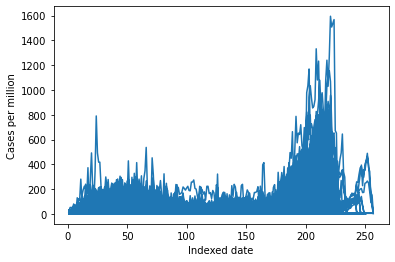

In [7]:
import matplotlib.pyplot as plt


plt.plot(CovidCasesSort['index'],CovidCasesSort['Cases per million'])
plt.ylabel('Cases per million')
plt.xlabel('Indexed date')
plt.show()



###### Determine at what index to take the test split

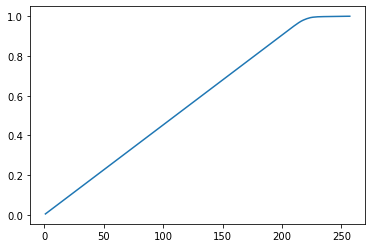

In [9]:
import numpy as np

test_train = CovidCasesSort.groupby('index').agg('count').reset_index()

bins = test_train['index'].unique()

test_train['cumsum'] = test_train['key'].cumsum() / test_train['key'].sum()

plt.plot(bins, np.array(test_train['cumsum']))

index_test_split = test_train['cumsum'][test_train['cumsum'] >= 0.8].index.min()


### 2 Feature engineering 

##### Take 3 day moving average to minimise effect of low weekend results.

In [10]:
CovidCasesMA = CovidCasesSort

CovidCasesMA['MA Cases per Million'] = CovidCasesMA.groupby('key')['Cases per million'].transform(lambda x: x.rolling(3, 1).mean())

#CovidCasesMA = CovidCasesMA[!pd.isnull(CovidCasesMA['Cases per million'])]['key'].unique()
CovidCasesMA = CovidCasesMA.dropna()



##### Scale values for LSTM

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()


CovidCasesMAScale = CovidCasesMA
#CovidCasesMAScale['Scaled'] = CovidCasesMAScale['MA Cases per Million'].apply(lambda x: MinMaxScaler(feature_range=(0, 1)).fit_transform(x))

CovidCasesMAScale['Scaled'] = scaler.fit_transform(CovidCasesMAScale[['MA Cases per Million']])

CovidCasesMAScale.head()

,key,geography,date,Cases per million,index,MA Cases per Million,Scaled
210,E06000001,Hartlepool,2020-03-16,10.676575,1.0,10.676575,0.006901
209,E06000001,Hartlepool,2020-03-17,0.000000,2.0,5.338287,0.003451
208,E06000001,Hartlepool,2020-03-18,10.676575,3.0,7.117716,0.004601
207,E06000001,Hartlepool,2020-03-19,0.000000,4.0,3.558858,0.002300
206,E06000001,Hartlepool,2020-03-20,10.676575,5.0,7.117716,0.004601


###### Create batches of 14 days plus 1 day as dependant variable - this takes a lot of time (new to python, usually work in R, don't know a faster way yet)

In [12]:
CovidFeatures = CovidCasesMAScale[['key','index','Scaled']]

CovidFeatures.head()

key = CovidFeatures['key'].unique().tolist()

forecast_length = int(14 + 1)

emptyDataFrame = pd.DataFrame(CovidFeatures.iloc[0:1,:])

emptyDataFrame['key time'] = str("Place Holder") + str("_") + emptyDataFrame['key']

geographies = {}
for code in key:
    geographies[code] = CovidFeatures[CovidFeatures['key'] == code]
    for time in range(int(geographies[code]['index'].max() - forecast_length)) :
        timestamp = geographies[code].iloc[time:time+forecast_length,:]
        key_time = timestamp['index'].min()
        timestamp['key time'] = timestamp['key'] + str("_") + str(key_time)
        emptyDataFrame = emptyDataFrame.append(timestamp)



###### Pivot and convert to numpy, shuffle, cut into Test / Train : defined by 0.8 of 0>max(index) 

In [142]:
KerasData = emptyDataFrame.iloc[1:,:]

length = int(KerasData.shape[0])

sequence = range(0,15)

sequence_repeat = int(KerasData.shape[0]/15)

KerasData['time index'] = np.tile(sequence, len(KerasData)//len(sequence)) + 1

KerasData = KerasData.pivot_table(index = ['key time'], columns = 'time index', values = 'Scaled').reset_index()

KerasData['Test or train'] = KerasData['key time'].str.slice(start = 10, stop = 20).astype(float).astype(int)

train = KerasData[KerasData['Test or train'] < index_test_split].drop(columns = ['key time','Test or train']).values.transpose()

test = KerasData[KerasData['Test or train'] >= index_test_split].drop(columns = ['key time','Test or train']).values.transpose()

train_data, train_label = train[:14,].transpose().reshape(train.shape[1], 14, 1), train[14:,].transpose().reshape(train.shape[1], 1, 1)

test_data, test_label = test[:14,].transpose().reshape(test.shape[1], 14, 1), test[14:,].transpose().reshape(test.shape[1], 1, 1)


time index,key time,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,Test or train
0,E06000001_1.0,0.006901,0.003451,4.600947e-03,2.300474e-03,4.600947e-03,2.300474e-03,2.300474e-03,0.000000e+00,0.000000,0.004601,6.901421e-03,1.150237e-02,1.380284e-02,1.380284e-02,0.020704,1
1,E06000001_10.0,0.004601,0.006901,1.150237e-02,1.380284e-02,1.380284e-02,2.070426e-02,2.070426e-02,2.530521e-02,0.018404,0.025305,3.220663e-02,3.450710e-02,4.140852e-02,5.291089e-02,0.059812,10
2,E06000001_100.0,0.011502,0.013803,6.901421e-03,2.300474e-03,8.267406e-17,8.267406e-17,8.267406e-17,8.267406e-17,0.002300,0.004601,4.600947e-03,2.300474e-03,8.267406e-17,8.267406e-17,0.002300,100
3,E06000001_101.0,0.013803,0.006901,2.300474e-03,8.267406e-17,8.267406e-17,8.267406e-17,8.267406e-17,2.300474e-03,0.004601,0.004601,2.300474e-03,8.267406e-17,8.267406e-17,2.300474e-03,0.002300,101
4,E06000001_102.0,0.006901,0.002300,8.267406e-17,8.267406e-17,8.267406e-17,8.267406e-17,2.300474e-03,4.600947e-03,0.004601,0.002300,8.267406e-17,8.267406e-17,2.300474e-03,2.300474e-03,0.004601,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71188,E92000001_95.0,0.036236,0.031424,3.298247e-02,3.543625e-02,3.683349e-02,3.479314e-02,2.913911e-02,2.455694e-02,0.026272,0.030609,3.395097e-02,3.066650e-02,2.762320e-02,2.337407e-02,0.021012,95
71189,E92000001_96.0,0.031424,0.032982,3.543625e-02,3.683349e-02,3.479314e-02,2.913911e-02,2.455694e-02,2.627190e-02,0.030609,0.033951,3.066650e-02,2.762320e-02,2.337407e-02,2.101216e-02,0.021334,96
71190,E92000001_97.0,0.032982,0.035436,3.683349e-02,3.479314e-02,2.913911e-02,2.455694e-02,2.627190e-02,3.060908e-02,0.033951,0.030667,2.762320e-02,2.337407e-02,2.101216e-02,2.133372e-02,0.024457,97
71191,E92000001_98.0,0.035436,0.036833,3.479314e-02,2.913911e-02,2.455694e-02,2.627190e-02,3.060908e-02,3.395097e-02,0.030667,0.027623,2.337407e-02,2.101216e-02,2.133372e-02,2.445741e-02,0.027374,98


### 3 Model Build

In [120]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation

# design network

timesteps = 14
dim = 1

model = Sequential()
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,return_sequences=True, dropout = 0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

hist = model.fit(x=train_data, y=train_label, shuffle=True, validation_data =(test_data, test_label), epochs = 10, batch_size = 64)

Epoch 1/20
947/947 [==============================] - 22s 23ms/step - loss: 0.0090 - val_loss: 0.0332
Epoch 2/20
947/947 [==============================] - 20s 21ms/step - loss: 0.0086 - val_loss: 0.0341
Epoch 3/20
947/947 [==============================] - 20s 21ms/step - loss: 0.0086 - val_loss: 0.0327
Epoch 4/20
947/947 [==============================] - 20s 21ms/step - loss: 0.0086 - val_loss: 0.0348
Epoch 5/20
947/947 [==============================] - 20s 22ms/step - loss: 0.0085 - val_loss: 0.0344
Epoch 6/20
947/947 [==============================] - 20s 21ms/step - loss: 0.0085 - val_loss: 0.0369
Epoch 7/20
947/947 [==============================] - 20s 21ms/step - loss: 0.0085 - val_loss: 0.0358 ETA: 0s - loss:
Epoch 8/20
947/947 [==============================] - 20s 21ms/step - loss: 0.0085 - val_loss: 0.0348
Epoch 9/20
947/947 [==============================] - 20s 21ms/step - loss: 0.0085 - val_loss: 0.0371
Epoch 10/20
947/947 [==============================] - 21s 23ms/st

Text(0.5, 0, 'Epocs')

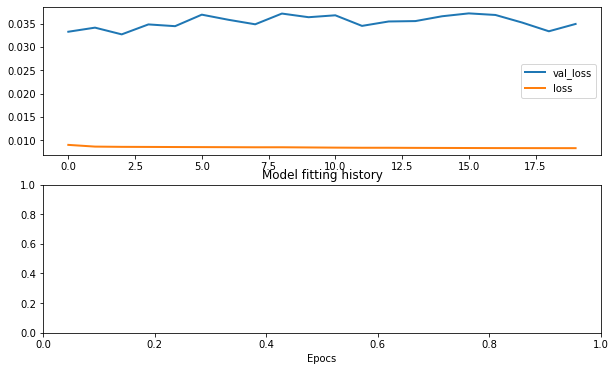

In [125]:
ModelHistory = pd.DataFrame(data = hist.history)
# Plot model history and save           
fig, axes = plt.subplots(nrows=2, ncols=1)
#fig.subplots_adjust(hspace=0.5)
ModelHistory[['val_loss', 'loss']].plot(linewidth=2, figsize=(10, 6), ax=axes[0])
plt.title('Model fitting history')
plt.xlabel('Epocs')



## 4 Model Evaluation

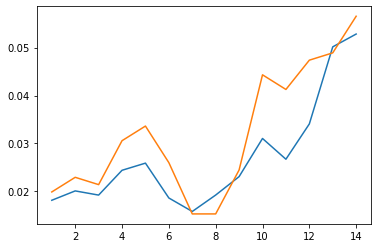

In [170]:
#Get prediction sample

Prediction_set = CovidCasesMAScale[CovidCasesMAScale['index'] > index_test_split - 15][CovidCasesMAScale['index'] < index_test_split ].drop(columns = ['date','Cases per million','MA Cases per Million'])
Prediction_set['index prediction'] = Prediction_set.groupby('key').cumcount()+1

Prediction_matrix = Prediction_set.pivot_table(index = ['key','geography'], columns = 'index prediction', values = 'Scaled').reset_index()

first_predict_set = Prediction_matrix.iloc[:,column+1:column+15].values.reshape(Prediction_matrix.shape[0],14,1)
first_predict_out = model.predict(first_predict_set[1].reshape(1,14,1), verbose=0)

plt.plot(np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14]), first_predict_out[0])
plt.plot(np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14]), first_predict_set[1])
    
#Evaluation_set = CovidCasesMAScale[CovidCasesMAScale['index'] > index_test_split].['date','Cases per million','MA Cases per Million'])
#Evaluation_set = Evaluation_set[Evaluation_set['index'] < index_test_split + 7]